<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/distinguishability_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigate Identifiability of Correlation Parameter with Different Modalities

This notebook simulates a dataset generated from our model for a two-gene system. It then calculates the log-likelihood of the results assuming different values of the &epsilon;
 parameter.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from FGP_2023.simulation import create_samples, visualize, pss_wrapper_n
from FGP_2023.construct_H import construct_H
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive
Package FGP_2023 is being imported!


## Simulate dataset of cells with joint ATAC and RNA information.

First we define a function to evaluate switching off rate, $k_{\rm off}$, which gives a specified probability for a gene to be on, $p_1$.

In [ ]:
def find_koff(e, kon, p1):
    '''
    Calculate the rate of gene switching off which gives a probability of p1 for each gene to be on.

    Args:
        e (float): epsilon parameter in Ising model
        kon (float): rate of gene switching on (assumed equal for both genes)
        p1 (float): desired probability for each gene to be on

    Output:
        koff: switching off rate for genes which gives the desired overall probability

    '''
    koff = 1/p1*0.5*(e*kon - 2*e*kon*p1 + ((e*kon-2*e*kon*p1)**2 + 4*p1*(kon**2 - kon**2*p1))**(1/2))

    return koff

## Create cell samples and visualize.
k_on = 0.1
p_on = 0.4
epsilon =0.3
k_off = find_koff(epsilon, k_on, p_on)
k_ons, bs, ds, number_of_cells, simulation_time= [k_on, k_on], [10,15], [5,7], 20000, 0.4/k_on

## Uncomment to visualize the simulated cells.
# visualize(k_ons, k_off, bs, ds, epsilon, number_of_cells, simulation_time)
t_arr,samples,H,A,C,init_state_prob, initcond = create_samples(k_ons, k_off, bs, ds, epsilon, number_of_cells, simulation_time)

100%|██████████| 20000/20000 [02:01<00:00, 164.92it/s]


## Functions for calculating log-likelihoods of data given an analytic distribution.

For each modality, we first extract from the simulated data the aspect which would be measured by that modality (gene-state information for ATAC, joint information for multiome). We then marginalize the analytic distribution as necessary and calculate log-likelihood.

In [ ]:
# Take output of create_samples and calculate log_likelihoods.
def log_likelihood(simulated_data, Pss_uncond, ATAC='registered', comparison='fixed_cell_num'):
    '''
    Calculate log likelihood of data given an analytic joint distribution, marginalizing the probabilities according to the available modality.

    Args:
        simulated_data: simulated cells as from simulation.create_samples for a two-gene system
            cells have form [[length state vector], [length-n transcript copy numbers]]
        Pss_uncond: analytic probability distribution indexed via Pss_uncond[transcript 1][transcript 2][gene-state]
        ATAC (string): which modality is being used to assess log-likelihood -
            'unregistered', 'registered', 'noRNA', 'noATAC'
        comparison (string): what to keep constant in the comparision - 'fixed_cell_num' or 'fixed_price'

    Output:
        log-likelihood of data
    '''

    total_cells = len(simulated_data)

    # Split the simulated cells into two batches.
    final_dist = simulated_data[:int(total_cells/2), -1, :]
    final_dist_extra = simulated_data[int(total_cells/2):, -1, :]

    # Calculate number of extra cells based on price.
    ATAC_price = 8210
    RNA_price = 8540
    multiome_price = 14710
    unreg_price = (ATAC_price + RNA_price)/2

    # For multiome, use half of the cells.
    # For the other modalities, use a certain number of cells from the second half of the cells to compensate for the cheaper price.
    if comparison == 'fixed_price':
      extra_cells_atac = int((multiome_price/ATAC_price - 1)*len(final_dist))
      extra_cells_rna = int((multiome_price/RNA_price - 1)*len(final_dist))
      extra_cells_unreg = int((multiome_price/unreg_price - 1)*len(final_dist))

    # # For fixed cell number, use half of the cells for all modalities.
    elif comparison == 'fixed_cell_num':
      extra_cells_atac, extra_cells_rna, extra_cells_unreg = 0, 0, 0
    else:
      print('Mis-specified')

    # For registered ATAC, calculate LL for the full joint probability distribution of gene state and RNA count.
    if ATAC == 'registered':
        LL = 0
        for cell in final_dist:
            n = int(cell[N])
            m = int(cell[N+1])
            for j in range(N):
                if cell[j]==1:
                    gene_state = j
            prob = Pss_uncond[n][m][gene_state]
            LL += np.log(prob)

    # For unregistered ATAC, calculate LL for the marginalized RNA count probabilities, and the marginalized gene state probabilities.
    elif ATAC == 'unregistered':
        margin = np.sum(Pss_uncond, axis=2)
        LL = 0

        # Add RNA info.
        total_cells = len(final_dist)
        for cell in np.concatenate((final_dist[:int(total_cells/2)],  final_dist_extra[:int(extra_cells_unreg/2)]), axis=0):
            n = int(cell[N])
            m = int(cell[N+1])
            prob = margin[n][m]
            LL += np.log(prob)

        gene_margin = np.sum(Pss_uncond, axis=0)
        gene_margin = np.sum(gene_margin, axis=0)

        # Add ATAC info.
        for cell in np.concatenate((final_dist[int(total_cells/2):],  final_dist_extra[int(extra_cells_unreg/2):int(extra_cells_unreg)]), axis=0):
            for j in range(N):
                if cell[j]==1:
                    gene_state = j
            prob = gene_margin[gene_state]
            LL += np.log(prob)

    # For ATAC data alone, marginalize over the RNA information.
    elif ATAC=='noRNA':
        LL = 0
        gene_margin = np.sum(Pss_uncond, axis=0)
        gene_margin = np.sum(gene_margin, axis=0)
        for cell in np.concatenate((final_dist, final_dist_extra[:extra_cells_atac]), axis=0):
            for j in range(N):
                if cell[j]==1:
                    gene_state = j
            prob = gene_margin[gene_state]
            LL += np.log(prob)

    # For no ATAC data, simply use marginalized RNA count probabilities.
    else:
        margin = np.sum(Pss_uncond, axis=2)
        LL = 0
        for cell in np.concatenate((final_dist, final_dist_extra[:extra_cells_rna]), axis=0):
            n = int(cell[N])
            m = int(cell[N+1])
            prob = margin[n][m]
            LL += np.log(prob)

    return LL


def remove_neg(Pss):
    '''
    Replace any negative values with very small positive values to avoid calculation errors.
    '''
    Pss[Pss<0] = min(Pss[Pss>0])
    Pss = Pss/np.sum(Pss)
    return Pss

## Calculate log-likelihood of the simulated data under different values of &epsilon; for each modality.
Calculate the change in log-likelihood measured for the different modalities as the assumed analytic distribution moves away from the generating distribution. In particular, as the &epsilon; value used to construct the Ising transition matrix moves away from its actual value. Perform this comparison either at fixed cell number for each modality, or at fixed experimental price.

In [ ]:
## Compare log-likelihoods of simulated data for different values of epsilon using each modality.

# Choose a range of epsilon values to calculate over.
epsilons = [10**(i/5) for i in range(-10,3)]
LLs, LLnons, LLnonregs, LLnoRNAs = [], [], [], []
n, N = 2,4 # species 2, states 4 for the two-gene system.
comparison = 'fixed_cell_num' # choose 'fixed_cell_num' or 'fixed_price'

# Establish range of transcript numbers to calculate analytic distributions over.
final_dist = samples[:, -1, :]
mx_uncond = [int(final_dist[:,N+1].max() + 10), int(final_dist[:,N+0].max() + 10)]

# Calculate the analytic distribution for the parameters used to generate simulated cells.
H_actual = construct_H(k_ons, k_off, epsilon)
Pss_uncond_real = remove_neg(pss_wrapper_n(H_actual,A,C,t_arr[-1],mx_uncond,n,N,initcond))

# Calculate the log-likelihood of the data under the parameters used to generate it for each modality.
LLnon_base = log_likelihood(samples, Pss_uncond_real, ATAC=False, comparison=comparison)
LL_base = log_likelihood(samples, Pss_uncond_real, ATAC='registered',comparison=comparison)
LLnonreg_base = log_likelihood(samples, Pss_uncond_real, ATAC='unregistered', comparison=comparison)
LLnoRNA_base = log_likelihood(samples, Pss_uncond_real, ATAC='noRNA', comparison=comparison)

# Calculate the difference in log-likelihood as we move away from the correct value of epsilon for each modality.
for e in epsilons:

    # Calculate new k_off to preserve p1.
    new_k_off = find_koff(e, k_on, p_on)

    # Calculate analytic distribution under the new parameters.
    H_new = construct_H([k_on, k_on], new_k_off, e)
    Pss_uncond = remove_neg(pss_wrapper_n(H_new,A,C,t_arr[-1],mx_uncond,n,N,initcond))

    # Calculate the difference in log-likelihood from the true distribution.
    LLnons += [log_likelihood(samples, Pss_uncond, ATAC=False, comparison=comparison) - LLnon_base]
    LLs += [log_likelihood(samples, Pss_uncond, ATAC='registered', comparison=comparison) - LL_base]
    LLnonregs += [log_likelihood(samples, Pss_uncond, ATAC='unregistered', comparison=comparison) - LLnonreg_base]
    LLnoRNAs += [log_likelihood(samples, Pss_uncond, ATAC='noRNA', comparison=comparison) - LLnoRNA_base]

/content/drive/MyDrive/Colab Notebooks/FGP_2023/simulation.py:461: RuntimeWarning: overflow encountered in exp
  Ufun = (np.exp(L*x)@coeff)
/content/drive/MyDrive/Colab Notebooks/FGP_2023/simulation.py:461: RuntimeWarning: invalid value encountered in matmul
  Ufun = (np.exp(L*x)@coeff)


## Plot log-likelihoods to show the identifiability of &epsilon; using each modality.

The sharpness of the peak around the true value of &epsilon; shows the information gained from each modality for parameter identification in this type of model.

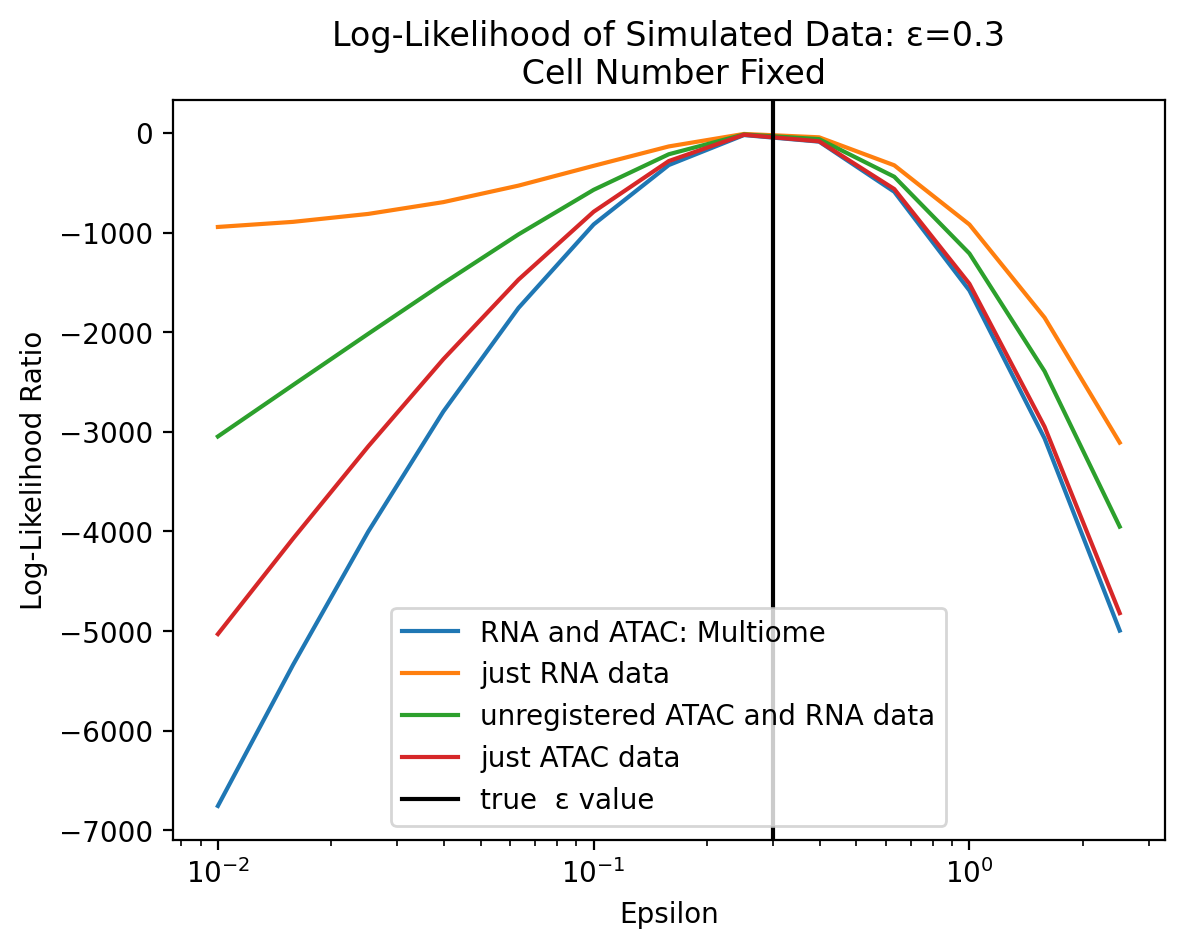

In [ ]:
## Plot log-likelihoods of simualted data for a range of epsilon for each modality. Figure as in Distinguishability Comparison of the main text.
plt.plot(epsilons, LLs, label='RNA and ATAC: Multiome')
plt.plot(epsilons, LLnons, label='just RNA data')
plt.plot(epsilons, LLnonregs, label='unregistered ATAC and RNA data') #+LLnons[24]-LLnonregs[24]
plt.plot(epsilons, LLnoRNAs, label='just ATAC data')
plt.axvline(x=0.3, label='true  \u03B5 value', color='black')

plt.xlabel('Epsilon')
plt.xscale('log')
plt.ylabel('Log-Likelihood Ratio')
comparison_labels = {'fixed_cell_num': 'Cell Number Fixed', 'fixed_price': 'Experimental Price Fixed'}
plt.title('Log-Likelihood of Simulated Data: \u03B5=' + str(epsilon) + '\n ' + comparison_labels[comparison])
plt.legend()